In [1]:
import gc
import os
import pickle
import jsonlines
import torch
from tqdm import tqdm
import pandas as pd
import csv
from collections import defaultdict
import argparse
from core.models.entailment import EntailmentDeberta
from rank_eval import load_rank_results, eval_rank_results
import os
import pickle
from core.computation.uncertainty_measure import cluster_assignment_entropy

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_samples(dataset_name, qid, doc_id):
    file_path = f'output/rank/gen/Qwen/Qwen2.5-7B-Instruct/{dataset_name}/{dataset_name}-{qid}-{doc_id}.pkl'
    if os.path.exists(file_path):
        result = load_pickle_file(file_path)
        return [x['text'] for x in result['sample']]
    return []


def load_cluster_ids(dataset_name, qid, doc_id):
    file_path = f'output/rank/cluster/Qwen/Qwen2.5-7B-Instruct/{dataset_name}/{dataset_name}-{qid}-{doc_id}.pkl'
    if os.path.exists(file_path):
        result = load_pickle_file(file_path)
        return result.get('cluster_ids', [])
    return []


# 计算语义熵
def compute_entropy(cluster_ids):
    if len(cluster_ids) == 0:
        return None
    return cluster_assignment_entropy(cluster_ids)


def load_dataset(dataset_path):
    query_path = os.path.join(dataset_path, 'queries.jsonl')
    queries = {}
    with jsonlines.open(query_path) as reader:
        for query in reader:
            queries[str(query['_id'])] = query['text']

    doc_path = os.path.join(dataset_path, 'corpus.jsonl')
    docs = {}
    with jsonlines.open(doc_path) as reader:
        for doc in reader:
            docs[str(doc['_id'])] = doc['text']

    rel_path = os.path.join(dataset_path, 'qrels/test.tsv')
    df = pd.read_csv(rel_path, sep='\t', header=0)
    
    scores = defaultdict(dict)
    for qid, docid, score in df.values:
        scores[str(qid)][str(docid)] = score
    
    return queries, docs, scores

all_data = {}
all_results = {}
all_scores = {}
size_name = "large"
dataset_names = ["trec-covid", "dbpedia-entity", "nfcorpus"]
for dataset_name in tqdm(dataset_names, desc='load dataset'):
    dataset_path = f'/home/song/dataset/beir/{dataset_name}'
    queries, docs, qrels = load_dataset(dataset_path)
    rank_result_path = f'dataset/rank/{dataset_name}/{dataset_name}-rank10-{size_name}.tsv'
    rank_results = load_rank_results(rank_result_path)
    rank_scores = eval_rank_results(rank_results, qrels, k_values=[1,3,5,10])
    all_data[dataset_name] = {
        'queries': queries,
        'docs': docs,
        'qrels': qrels,
    }
    all_results[dataset_name] = {
        'rank_results': rank_results,
    }
    all_scores[dataset_name] = {
        'rank_scores': rank_scores,
    }

load dataset: 100%|██████████| 3/3 [00:17<00:00,  5.91s/it]


In [2]:
for dataset_name in tqdm(dataset_names, desc='load dataset'):
    def get_doc_entropy(qid, docid='no'):
        cluster_ids = load_cluster_ids(dataset_name, qid, docid)
        entropy = compute_entropy(cluster_ids)
        return entropy
    rank_results = all_results[dataset_name]['rank_results']
    query_entropies = {}
    doc_entropy_results = {}
    diff_entropy_results = {}
    rank_index_results = {} # 10-i作为分数
    
    for qid in rank_results:
        query_entropies[qid] = get_doc_entropy(qid)
        doc_entropy_results[qid] = {}
        diff_entropy_results[qid] = {}
        rank_index_results[qid] = {}
        for i, docid in enumerate(rank_results[qid]):
            no_doc_entropy = get_doc_entropy(qid, 'no')
            doc_entropy = get_doc_entropy(qid, docid)
            doc_entropy_results[qid][docid] = -doc_entropy
            diff_entropy_results[qid][docid] = no_doc_entropy - doc_entropy
            rank_index_results[qid][docid] = 10.0 - i

    all_data[dataset_name]['query_entropies'] = query_entropies
    all_results[dataset_name]['doc_entropy_results'] = doc_entropy_results
    all_results[dataset_name]['diff_entropy_results'] = diff_entropy_results
    all_results[dataset_name]['rank_index_results'] = rank_index_results

load dataset: 100%|██████████| 3/3 [00:16<00:00,  5.59s/it]


In [3]:
# 保存数据
data = {
    'all_data': all_data,
    'all_results': all_results,
    'all_scores': all_scores,
}
save_pickle_file('output/export/data.pkl', data)

In [3]:
ALL_THRESHOLDS = [x/10 for x in range(-30, 31, 1)]
', '.join(map(str, ALL_THRESHOLDS))

'-3.0, -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0'

In [ ]:
def calculate_score(rank_score, diff_entropy_score, doc_entropy, nodoc_entropy, threshold):
    if diff_entropy_score is None or doc_entropy is None or nodoc_entropy is None:
        return rank_score
    if no_doc_entropy < 0.1: # 不带doc的语义熵就很低
        return rank_score
    if doc_entropy > 0.1: # 加上doc后语义熵不够低
        return rank_score
    if nodoc_entropy - doc_entropy > threshold: # 语义熵减少的足够多
        return rank_score
    return rank_score - 1.0 # 语义熵减少的不够多

for dataset_name in tqdm(dataset_names, desc='calulate'):
    threshold_results = {}
    for threshold in ALL_THRESHOLDS:
        # rank_results = all_results[dataset_name]['rank_results']
        rank_results = all_results[dataset_name]['rank_index_results']
        new_results = defaultdict(dict)
        for qid in rank_results:
            for docid in rank_results[qid]:
                new_results[qid][docid] = calculate_score(rank_results[qid][docid], all_results[dataset_name]['diff_entropy_results'][qid][docid], all_results[dataset_name]['doc_entropy_results'][qid][docid], all_data[dataset_name]['query_entropies'][qid], threshold)
        threshold_results[threshold] = new_results
    all_results[dataset_name]['threshold_results'] = threshold_results

calulate:   0%|          | 0/3 [00:00<?, ?it/s]

calulate: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


In [17]:
all_results['trec-covid']['threshold_results'][2]

defaultdict(dict,
            {'29': {'38d6gb7o': 10.0,
              'eje3i558': 8.0,
              '7qd8z5e7': 8.0,
              '74xvvwrw': 6.0,
              '5vgfliv0': 5.0,
              'yv2gjjzg': 4.0,
              'uuy94dwa': 3.0,
              'qrfx165d': 2.0,
              '2cvvkrx9': 1.0,
              'eja8fkwv': 0.0},
             '49': {'kqanoog7': 9.0,
              'qg01p4bq': 8.0,
              '8aezcyf9': 7.0,
              '5lhvix51': 6.0,
              'eg84q35t': 5.0,
              '9iuesnxo': 4.0,
              'qyo9x78w': 3.0,
              '871812f7': 2.0,
              'q5i8lpan': 1.0,
              '58sc6xgq': 0.0},
             '41': {'97mg41jl': 9.0,
              'ujlsdpzf': 8.0,
              'ey1sqch4': 7.0,
              'crqvdk4k': 6.0,
              'i6a26q3j': 5.0,
              'fs983x5g': 4.0,
              '9zjtwp19': 3.0,
              'cv3op3bb': 2.0,
              'vgtc0k3a': 1.0,
              '92o3dujh': 0.0},
             '20': {'nxrg9fi6'

In [18]:
for dataset_name in tqdm(dataset_names, desc='eval'):
    for threshold in ALL_THRESHOLDS:
        threshold_results = all_results[dataset_name]['threshold_results'][threshold]
        rank_scores = eval_rank_results(threshold_results, all_data[dataset_name]['qrels'], k_values=[1,3,5,10])
        all_scores[dataset_name][f'threshold_{threshold}'] = rank_scores

eval: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


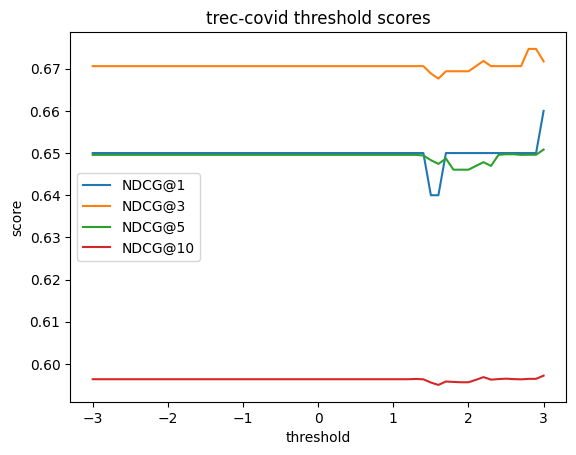

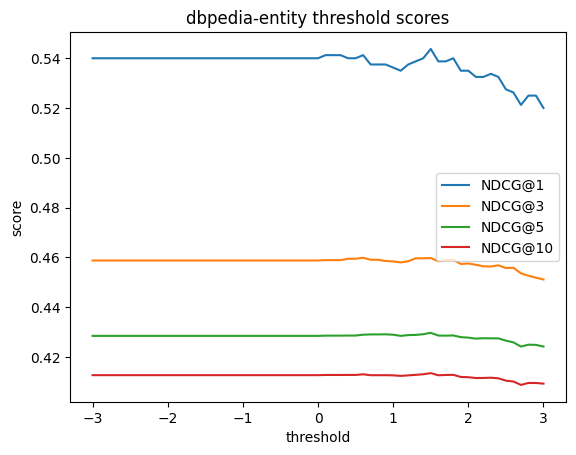

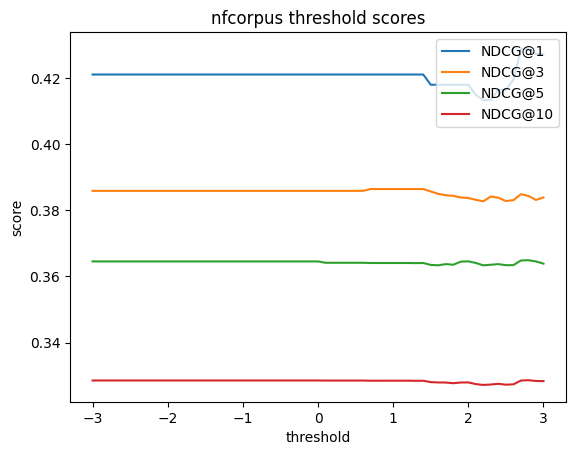

In [19]:
# 绘制直线图，对比不同阈值下的评价指标
def plot_scores(score_names, scores, thresholds, title):
    import matplotlib.pyplot as plt
    plt.figure()
    for k1, k2 in score_names:
        score_values = [scores[f'threshold_{threshold}'][k1][k2] for threshold in thresholds]
        plt.plot(thresholds, score_values, label=k2)
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.title(title)
    plt.legend()
    plt.show()

for dataset_name in dataset_names:
    # k = 5
    # score_names = [('ndcg', f'NDCG@{k}'), ('precision', f'P@{k}'), ('recall', f'Recall@{k}'), ('map', f'MAP@{k}'), ('mrr', f'MRR@{k}'), ('recall_cap', f'R_cap@{k}')]
    score_names = [('ndcg', f'NDCG@{k}') for k in [1,3,5,10]]
    scores = all_scores[dataset_name]
    thresholds = ALL_THRESHOLDS
    plot_scores(score_names, scores, thresholds, f'{dataset_name} threshold scores')


In [20]:
# for dataset_name in dataset_names:
#     k = 1
#     score_names = [('ndcg', f'NDCG@{k}'), ('precision', f'P@{k}'), ('recall', f'Recall@{k}'), ('map', f'MAP@{k}'), ('mrr', f'MRR@{k}'), ('recall_cap', f'R_cap@{k}')]
#     scores = all_scores[dataset_name]
#     thresholds = ALL_THRESHOLDS
#     plot_scores(score_names, scores, thresholds, f'{dataset_name} threshold scores')


In [21]:



    
    
    # def get_no_doc(qid):
    #     docid = 'no'
    #     samples = load_samples(dataset_name, qid, docid)
    #     samples_text = '|'.join(samples)
    #     cluster_ids = load_cluster_ids(dataset_name, qid, docid)
    #     cluster_text = '|'.join([str(x) for x in cluster_ids])
    #     entropy = compute_entropy(cluster_ids)
    #     return (samples_text, cluster_text, entropy)

    # merge_results = []
    # for qid in rank_results:
    #     no_doc_samples, no_doc_clusters, no_doc_entropy = get_no_doc(qid)
    #     items = []
    #     for i, docid in enumerate(rank_results[qid]):
    #         samples = load_samples(dataset_name, qid, docid)
    #         samples_text = '|'.join(samples)
    #         cluster_ids = load_cluster_ids(dataset_name, qid, docid)
    #         cluster_text = '|'.join([str(x) for x in cluster_ids])
    #         entropy = compute_entropy(cluster_ids)
    #         items.append([str(qid), # qid
    #                         queries.get(str(qid), ''), # query
    #                         str(docid), # docid
    #                         docs.get(str(docid), ''), # doc
    #                         scores.get(str(qid), {}).get(str(docid), 0.0), # gold_score
    #                         rank_results.get(qid, {}).get(docid, 0.0), # rank_score
    #                         entropy, # doc_entropy
    #                         no_doc_entropy, # no_doc_entropy
    #                         merge_score(rank_results.get(qid, {}).get(docid, 0.0), entropy, no_doc_entropy), # merge_score
    #                         samples_text, # doc_samples
    #                         cluster_text, # doc_clusters
    #                         no_doc_samples, # no_doc_samples
    #                         no_doc_clusters, # no_doc_clusters
    #                         i, # rank_index
    #                         i, # merge_index
    #                         0, # diff_index
    #                         ])
    #     # 按照merge_score排序
    #     items.sort(key=lambda x: x[8], reverse=True)
    #     for i, item in enumerate(items):
    #         item[-2] = i
    #         item[-1] = i - item[-3]
    #     merge_results.extend(items)
    # output_file_path = f'output/export/{dataset_name}-{size_name}.tsv'
    # os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
    # with open(output_file_path, 'w', newline='') as f:
    #     writer = csv.writer(f, delimiter='\t')
    #     writer.writerow(['qid', 'query', 'docid', 'doc', 'gold_score', 'rank_score', 'doc_entropy', 'no_doc_entropy', 'merge_score', 'doc_samples', 'doc_clusters', 'no_doc_samples', 'no_doc_clusters', 'rank_index', 'merge_index', 'diff_index'])
    #     writer.writerows(merge_results)
    # print(output_file_path)
